In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [34]:
samsung = pd.read_csv('samsung0910.csv')
samsung = samsung[::-1]
samsung = samsung.drop(['시가','고가','저가','거래량','등락률'], axis=1)
samsung['종가'] = samsung['종가'].map(lambda x: int(re.sub(r',', '', x)))
test = samsung.iloc[-20:, :]
samsung = samsung.iloc[:-20, :]
test.reset_index(drop=True, inplace=True)
samsung.reset_index(drop=True, inplace=True)
samsung.columns = ['date', 'close']
test.columns = ['date', 'close']

samsung['date'] = pd.to_datetime(samsung.date, format='%Y-%m-%d')
samsung = samsung.set_index('date')
print(samsung.info())
print()
test['date'] = pd.to_datetime(test.date, format='%Y-%m-%d')
test = test.set_index('date')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560 entries, 2018-05-04 to 2020-08-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   560 non-null    int64
dtypes: int64(1)
memory usage: 8.8 KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2020-08-13 to 2020-09-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   20 non-null     int64
dtypes: int64(1)
memory usage: 320.0 bytes
None


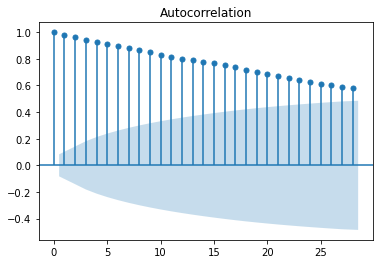

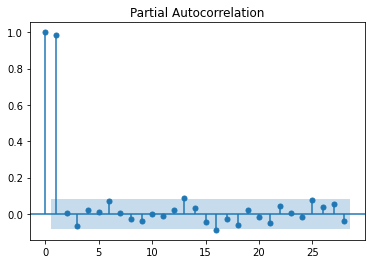

In [35]:
plot_acf(samsung) # ACF plot
plot_pacf(samsung) # PACF plot
plt.show()

In [36]:
y = samsung['close']
y_1diff = samsung.diff().dropna()['close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -1.6517
원 데이터 p-value :  0.4562
1차 차분 ADF Statistic : -15.2293
1차 차분 p-value :  0.0000


In [42]:
model = ARIMA(samsung, order=(1,1,0)) # freq='D'
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  559
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4565.487
Method:                       css-mle   S.D. of innovations            852.610
Date:                Fri, 11 Sep 2020   AIC                           9136.975
Time:                        08:25:04   BIC                           9149.953
Sample:                             1   HQIC                          9142.043
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6847     35.855      0.354      0.724     -57.590      82.960
ar.L1.D.close    -0.0058      0.042     -0.136      0.892      -0.089       0.077
                                    Root

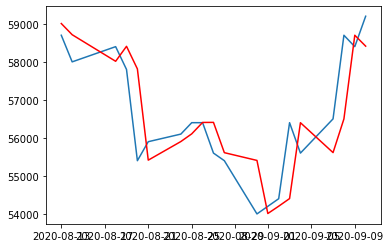

In [43]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    tmp = test['close'][i]
    history.append(tmp)

plt.plot(test.index, test['close'])
plt.plot(test.index, predictions, color='red')
plt.show()

In [44]:
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(samsung, [3,3,3])
result

,order,AIC
25,p2 d2 q1,9125.802942
7,p0 d2 q1,9126.428990
26,p2 d2 q2,9127.375880
17,p1 d2 q2,9128.318261
16,p1 d2 q1,9128.403325
8,p0 d2 q2,9128.407387
5,p0 d1 q2,9133.987853
21,p2 d1 q0,9134.329970
3,p0 d1 q0,9134.993376
14,p1 d1 q2,9135.720874


In [47]:
model = ARIMA(samsung, order=(0,2,1)) # freq='D'
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.close   No. Observations:                  558
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4560.991
Method:                       css-mle   S.D. of innovations            853.849
Date:                Fri, 11 Sep 2020   AIC                           9125.983
Time:                        08:26:11   BIC                           9134.631
Sample:                             2   HQIC                          9129.360
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ma.L1.D2.close    -0.9988      0.016    -63.020      0.000      -1.030      -0.968
                                    Roots                                    
                  Real          Imaginary

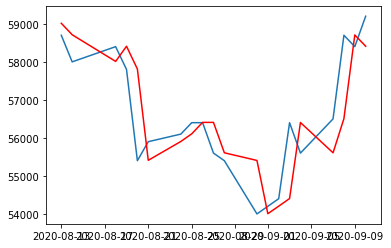

In [48]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit(trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    tmp = test['close'][i]
    history.append(tmp)

plt.plot(test.index, test['close'])
plt.plot(test.index, predictions, color='red')
plt.show()

In [51]:
today = model_fit.forecast()
today

(array([58411.77155128]),
 array([860.01483603]),
 array([[56726.17344649, 60097.36965607]]))